In [17]:
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import matplotlib

# Reading Data

In [2]:
remove_chars = [chr(x) for x in range(31)]
add_spaces = ["[", "]", "(", ")", "`", ":", ".", ";", "{", "}"]
def segmentWords(s): 
    # Remove non-printable characters, change remove ending apostrophe or apostrophe s, as those
    # make the dataset more sparse, and dont provide additional value regarding sentiment in the bag of words model.
    # (Most of the time its just making an extra word for a proper noun)
    for char in remove_chars:
        s = s.replace(char,"")
    for char in add_spaces:
        s = s.replace(char,char + " ")
    words = [word if not word.endswith("'s") else word[:-2] for word in s.split()]
    return [word if not word.endswith("'") else word[:-1] for word in words]

    

def readFile(fileName):
    # Function for reading file
    # input: filename as string
    # output: contents of file as list containing single words
    contents = []
    f = open(fileName)
    for line in f:
        contents.append(line)
    f.close()
    result = segmentWords('\n'.join(contents))
    return result

#### Create a Dataframe containing the counts of each word in a file

In [3]:
d = []

for c in os.listdir("data_training"):
    directory = "data_training/" + c
    for file in os.listdir(directory):
        words = readFile(directory + "/" + file)
        e = {x:words.count(x) for x in words}
        e['__FileID__'] = file
        e['is_positive'] = 1 if c == 'pos' else 0
        e['num_words'] = sum([1 for x in words if len(x) > 1]) #Exclude punctuation and empty strings
        d.append(e)

Create a dataframe from d - make sure to fill all the nan values with zeros.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html


In [4]:
df = pd.DataFrame(data=d,index=None)
if '' in df.columns:
    df.drop('', inplace=True, axis=1)
df.fillna(value=0,axis=0,inplace=True)
df = df.astype(np.int32, errors='ignore') # Become slightly more memory efficient, because my computer is a potato.
del d

#### Split data into training and validation set 

* Sample 80% of your dataframe to be the training data

* Let the remaining 20% be the validation data (you can filter out the indicies of the original dataframe that weren't selected for the training data)

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [6]:
traindf, validatedf = train_test_split(df, test_size=0.2)

* Split the dataframe for both training and validation data into x and y dataframes - where y contains the labels and x contains the words

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html

In [7]:
traindf_x = traindf.drop('is_positive', axis=1)
traindf_x.drop('__FileID__', inplace=True, axis=1)
traindf_y = pd.DataFrame(traindf['is_positive'])

validatedf_x = validatedf.drop('is_positive', axis=1)
validatedf_x.drop('__FileID__', inplace=True, axis=1)
validatedf_y = pd.DataFrame(validatedf['is_positive'])

# Logistic Regression

#### Basic Logistic Regression
* Use sklearn's linear_model.LogisticRegression() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### Changing Parameters

#### Feature Selection
* In the backward stepsize selection method, you can remove coefficients and the corresponding x columns, where the coefficient is more than a particular amount away from the mean - you can choose how far from the mean is reasonable.

References:

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.where.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.std.html
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mean.html

How did you select which features to remove? Why did that reduce overfitting?

# Single Decision Tree

#### Basic Decision Tree

* Initialize your model as a decision tree with sklearn.
* Fit the data and labels to the model.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [39]:
def most_important_features(dtc):
    lst = []
    for i in range(len(dtc.feature_importances_)):
        if dtc.feature_importances_[i] > 0:
            lst.append([dtc.feature_importances_[i], df.columns[i]])
    lst.sort(key=lambda x: x[0], reverse=True)
    return lst
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=9)
dt_clf.fit(traindf_x, traindf_y)
print("Decision tree score: ", dt_clf.score(validatedf_x, validatedf_y))

Decision tree score:  0.659375


#### Changing Parameters
* To test out which value is optimal for a particular parameter, you can either loop through various values or look into sklearn.model_selection.GridSearchCV

References:


http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [34]:
parameters = {'criterion':['entropy'], 'max_depth':[x for x in range(3,17)]}
clf = GridSearchCV(DecisionTreeClassifier(), parameters)
clf.fit(X=traindf_x, y=traindf_y['is_positive'].values)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.65234375 {'criterion': 'entropy', 'max_depth': 10}


In [37]:
train_scores = []
valid_scores = []
x = [x for x in range(1, 20)]
num_trials = 5
for depth in x:
    training_score = 0
    validation_score = 0
    for i in range(num_trials):
        clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
        clf.fit(traindf_x, traindf_y)
        training_score += clf.score(traindf_x, traindf_y)
        validation_score += clf.score(validatedf_x, validatedf_y)
    train_scores += [training_score / num_trials]
    valid_scores += [validation_score / num_trials]
print("Highest validation score is: " + str(max(valid_scores)))

Highest validation score is: 0.67125


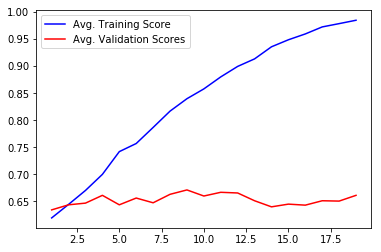

In [38]:
plt.plot(x, train_scores, color='b', label="Avg. Training Score")
plt.plot(x, valid_scores, color='r', label="Avg. Validation Scores")
plt.legend()
plt.show()

How did you choose which parameters to change and what value to give to them? Feel free to show a plot.

I chose to change the maximum depth parameter. I chose to vary this parameter, as lowering the maximum depth helps prevent the decision tree from overfitting. Thus it seemed sensible to try to find the optimal max depth to increase the validation scores. I have determined the value to give it from the above plot, and the GridSearchCV. The plot I made is a graph of the average decision tree accuracy on the training data and test data, with 5 samples per depth. The above plot indicates that the maximum validation score occurs at a maximum depth of 9, whereas the GridSearch indicates it occurs at 10. However, the validation scores for my plot at a depth of 9 are greater than the grid searches validation scores, hence I chose to use a maximum depth of 9 for the data. 

Why is a single decision tree so prone to overfitting?

A single decision tree can train to fit the training data exactly, and thus accounts for details present within the training data that aren't representative of the true underlying relationships.

As an interesting sidenote, lets see which words are the most indicative of the data being positive / negative. 

In [42]:
print(most_important_features(dt_clf)[:10])

[[0.093522069863377688, 'bacteria'], [0.084566191203167593, 'ancy'], [0.036023681494288709, 'gesundheit'], [0.025825117978578466, 'scribe'], [0.025673019678847379, 'frollo'], [0.02492649223053935, 'allowing'], [0.021046869875050139, 'poop'], [0.018471627517358563, 'borgnine'], [0.01768381459365128, 'missing'], [0.01653880250609523, 'robes']]


These words really don't look they should be indicative of movie reviews in general. I wouldn't expect bacteria, gesundheit, and frollo to appear in the vast majority of reviews.

# Random Forest Classifier

#### Basic Random Forest

* Use sklearn's ensemble.RandomForestClassifier() to create your model.
* Fit the data and labels with your model.
* Score your model with the same data and labels.

References:

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


#### Changing Parameters

What parameters did you choose to change and why?

How does a random forest classifier prevent overfitting better than a single decision tree?